In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re

import string
#from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [2]:
df=pd.read_csv('../csv/product_product.csv')

In [3]:
df.describe()

,overall,count
count,346355.000000,346355.000000
mean,4.274958,19.536493
std,1.120213,28.546791
min,1.000000,5.000000
25%,4.000000,6.000000
50%,5.000000,10.000000
75%,5.000000,20.000000
max,5.000000,1089.000000


In [4]:
def min_reviews_req(df):
    x=df.describe()
    min_count=x.loc['50%','count']
    #considering top 50% products by reviews count......
    new_df=df[df['count']>=min_count]
    return new_df
    
    

In [5]:
new_df=min_reviews_req(df)

In [6]:
new_df.index.size

181489

In [7]:
new_df.head()

,asin,summary,overall,count
164866,B002DWA2H4,med cabinet standard,5,10
164867,B002DWA2H4,So glad the ban on Excedrin was lifted,4,10
164868,B002DWA2H4,my go to,5,10
164869,B002DWA2H4,My old stand-by,5,10
164870,B002DWA2H4,Nothing better for my headaches,5,10


In [8]:
new_df.describe()

,overall,count
count,181489.000000,181489.000000
mean,4.273548,31.369185
std,1.103638,35.486832
min,1.000000,10.000000
25%,4.000000,13.000000
50%,5.000000,19.000000
75%,5.000000,37.000000
max,5.000000,1089.000000


In [9]:
dfProductReview=new_df.groupby("asin", as_index=False).mean()

In [10]:
dfProductReview.asin.unique().size

9234

In [11]:
ProductReviewSummary = new_df.groupby("asin")["summary"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.reset_index(inplace=True)

In [12]:
ProductReviewSummary.head()

,asin,summary
0,B002DWA2H4,"[med cabinet standard, So glad the ban on Exce..."
1,B002DWA3AA,"[Palatable, Tasty and helpful, Not perfect but..."
2,B002DXZIOU,"[Nice, Great, Good product, bad packaging, I d..."
3,B002DYIZIU,"[No Rush But Certainly Helpful, Need Your BCAA..."
4,B002DYIZO4,"[Flavored Beta-Alanine, WHAT?!, Beta Alanine (..."


In [13]:
ProductReviewSummary.to_csv("../csv/ProductReviewSummary.csv",index=False)

In [14]:
ProductReviewSummary=pd.read_csv("../csv/ProductReviewSummary.csv")

In [15]:
ProductReviewSummary.head()

,asin,summary
0,B002DWA2H4,"['med cabinet standard', 'So glad the ban on E..."
1,B002DWA3AA,"['Palatable', 'Tasty and helpful', 'Not perfec..."
2,B002DXZIOU,"['Nice', 'Great', 'Good product, bad packaging..."
3,B002DYIZIU,"['No Rush But Certainly Helpful', 'Need Your B..."
4,B002DYIZO4,"['Flavored Beta-Alanine, WHAT?!', 'Beta Alanin..."


In [16]:
dfMerged=pd.merge(ProductReviewSummary,dfProductReview,on='asin')

In [17]:
dfMerged.drop('count',inplace=True,axis=1)

In [18]:
dfMerged.head()

,asin,summary,overall
0,B002DWA2H4,"['med cabinet standard', 'So glad the ban on E...",4.888889
1,B002DWA3AA,"['Palatable', 'Tasty and helpful', 'Not perfec...",4.437500
2,B002DXZIOU,"['Nice', 'Great', 'Good product, bad packaging...",4.214286
3,B002DYIZIU,"['No Rush But Certainly Helpful', 'Need Your B...",4.022727
4,B002DYIZO4,"['Flavored Beta-Alanine, WHAT?!', 'Beta Alanin...",5.000000


# Text Cleaning - Summary column

In [19]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = str.lower(reviewText)
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [20]:
dfMerged.head()

,asin,summary,overall
0,B002DWA2H4,"['med cabinet standard', 'So glad the ban on E...",4.888889
1,B002DWA3AA,"['Palatable', 'Tasty and helpful', 'Not perfec...",4.437500
2,B002DXZIOU,"['Nice', 'Great', 'Good product, bad packaging...",4.214286
3,B002DYIZIU,"['No Rush But Certainly Helpful', 'Need Your B...",4.022727
4,B002DYIZO4,"['Flavored Beta-Alanine, WHAT?!', 'Beta Alanin...",5.000000


In [21]:
#reset index and drop duplicate rows
dfMerged['clean_summary'] = dfMerged['summary'].apply(lambda x:cleanReviews(x))
#dfMerged = dfMerged.drop_duplicates(['overall'], keep='last')
#dfMerged = dfMerged.reset_index()

In [22]:
dfMerged.index.size

9234

In [23]:
dfMerged.head()

,asin,summary,overall,clean_summary
0,B002DWA2H4,"['med cabinet standard', 'So glad the ban on E...",4.888889,med cabinet standard so glad the ban on excedr...
1,B002DWA3AA,"['Palatable', 'Tasty and helpful', 'Not perfec...",4.437500,palatable tasty and helpful not perfect but cl...
2,B002DXZIOU,"['Nice', 'Great', 'Good product, bad packaging...",4.214286,nice great good product bad packaging i don t ...
3,B002DYIZIU,"['No Rush But Certainly Helpful', 'Need Your B...",4.022727,no rush but certainly helpful need your bcaas ...
4,B002DYIZO4,"['Flavored Beta-Alanine, WHAT?!', 'Beta Alanin...",5.000000,flavored beta alanine what beta alanine bka th...


In [24]:
reviews = dfMerged["clean_summary"] 
countVector = CountVectorizer(max_features = 400, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

In [25]:
transformedReviews.A
#print(transformedReviews)
dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

In [26]:
product_id=pd.DataFrame()
product_id[['asin','overall']]=dfMerged[['asin','overall']]

In [27]:
product_id.to_csv("../csv/product_id.csv",index=False,sep=',')

In [28]:
product_id=pd.read_csv("../csv/product_id.csv")

In [29]:
product_id.head()

,asin,overall
0,B002DWA2H4,4.888889
1,B002DWA3AA,4.437500
2,B002DXZIOU,4.214286
3,B002DYIZIU,4.022727
4,B002DYIZO4,5.000000


In [30]:
dfReviews=product_id.join(dfReviews)

In [31]:
#save 
dfReviews.to_csv("../csv/Summary_Feature.csv",index=False)

In [32]:
dfReviews=pd.read_csv("../csv/Summary_Feature.csv")

In [33]:
from sklearn.cross_validation import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
#test train spilt.....
train,test=train_test_split(dfReviews,test_size=0.3)
print("Train sample size ",train.index.size)
print("Test sample size ",test.index.size)

train_features=train.drop(['asin','overall'],axis=1)
test_features=test.drop(['asin','overall'],axis=1)
           
train_array=np.array(train_features)
test_array=np.array(test_features)

Train sample size  6463
Test sample size  2771


In [35]:
train.to_csv('../csv/train.csv',index=False)
test.to_csv('../csv/test.csv',index=False)

In [36]:
train=pd.read_csv('../csv/train.csv')
test=pd.read_csv('../csv/test.csv')

In [37]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
neighbor.fit(train.drop(['asin','overall'],axis=1))
#using knn algo for predictions..
distances, indices = neighbor.kneighbors(train_array)

In [38]:
test.head()

,asin,overall,absolutely,accurate,actually,advertised,aid,allergy,alternative,amazing,...,worked,working,workout,works,worth,wow,year,years,yes,yummy
0,B004J80HSE,3.200000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B0098SL7OI,4.384615,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,B002YLT7VG,4.571429,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
3,B002ON394U,4.111111,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002XJKWO0,4.333333,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
product_id.iloc[0]['asin']

'B002DWA2H4'

In [45]:
test.asin.iloc[1]

'B004NCJXIG'

In [46]:
#find most related products
for i in range(test.index.size):
    a = neighbor.kneighbors([test_array[i]])
    #print(a)
    print(a[0])
    print(a[1])
    related_product_list = a[1]
    
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
                             
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    third_related_product = [item[2] for item in related_product_list]
    third_related_product = str(third_related_product).strip('[]')
    third_related_product = int(third_related_product)
    
    test_product=test.asin.iloc[i]
    s1=product_id['asin'][first_related_product]
    s2=product_id['asin'][second_related_product]
    s3=product_id['asin'][third_related_product]
    

    print ("Based on product reviews, for ",test_product," average rating is ",test.overall.iloc[i])
    print ("The first similar product is ", s1 ," average rating is ",product_id["overall"][first_related_product])
    print ("The second similar product is ",s2 ," average rating is ",product_id["overall"][second_related_product])
    print ("The third similar product is ",s3 ," average rating is ",product_id["overall"][third_related_product])
    print ("\n")
    

[[ 2.44948974  2.44948974  2.44948974]]
[[3977  304 2908]]
Based on product reviews, for  B0062N789U  average rating is  5.0
The first similar product is  B004XMTH0A  average rating is  4.0
The second similar product is  B002L4M4M0  average rating is  4.77777777778
The third similar product is  B0047GSHOE  average rating is  3.33333333333


[[ 11.18033989  11.61895004  11.61895004]]
[[3263 1368  686]]
Based on product reviews, for  B004NCJXIG  average rating is  3.25
The first similar product is  B004GW4S0G  average rating is  4.30555555556
The second similar product is  B0036THN8E  average rating is  3.36842105263
The third similar product is  B002SMJQT4  average rating is  4.3417721519


[[ 3.31662479  3.60555128  3.60555128]]
[[4207 2029 2189]]
Based on product reviews, for  B005BGBX7C  average rating is  3.42857142857
The first similar product is  B0054GP8RK  average rating is  4.0
The second similar product is  B003LZOHNW  average rating is  4.83333333333
The third similar product

[[1583 1290 1508]]
Based on product reviews, for  B0036THMJY  average rating is  4.66666666667
The first similar product is  B003B3P4PY  average rating is  4.63636363636
The second similar product is  B0035G0786  average rating is  4.6511627907
The third similar product is  B0039NN14M  average rating is  4.2


[[ 15.16575089  16.          16.0623784 ]]
[[3581 1620 4080]]
Based on product reviews, for  B0041CZJWW  average rating is  4.80952380952
The first similar product is  B004P2DUNS  average rating is  4.4
The second similar product is  B003BKRMGG  average rating is  3.57142857143
The third similar product is  B0050DO1B6  average rating is  4.86206896552


[[ 2.82842712  2.82842712  2.82842712]]
[[2691  304  535]]
Based on product reviews, for  B005MRURFY  average rating is  4.4
The first similar product is  B0042KOJRE  average rating is  4.88888888889
The second similar product is  B002L4M4M0  average rating is  4.77777777778
The third similar product is  B002QPA8B8  average rating

[[ 3.16227766  3.31662479  3.46410162]]
[[  75 5167  181]]
Based on product reviews, for  B00BQWPWYK  average rating is  4.4
The first similar product is  B002FKLGW4  average rating is  3.85714285714
The second similar product is  B00657YP94  average rating is  4.44827586207
The third similar product is  B002IGW15G  average rating is  4.66666666667


[[ 12.28820573  12.36931688  12.56980509]]
[[5885 3682  709]]
Based on product reviews, for  B00HHEPECQ  average rating is  4.91836734694
The first similar product is  B007MRL972  average rating is  4.57142857143
The second similar product is  B004R8UPR4  average rating is  4.71428571429
The third similar product is  B002T4F8AW  average rating is  3.46153846154


[[ 4.89897949  4.89897949  5.        ]]
[[1235 1676 4015]]
Based on product reviews, for  B008O2T2P0  average rating is  4.2
The first similar product is  B0033TA8K2  average rating is  3.7
The second similar product is  B003CFB2A2  average rating is  3.85714285714
The third simil

[[ 2.82842712  2.82842712  2.82842712]]
[[2908  304 1290]]
Based on product reviews, for  B00F84FRHO  average rating is  5.0
The first similar product is  B0047GSHOE  average rating is  3.33333333333
The second similar product is  B002L4M4M0  average rating is  4.77777777778
The third similar product is  B0035G0786  average rating is  4.6511627907


[[ 11.          11.04536102  11.26942767]]
[[5345 2971 3640]]
Based on product reviews, for  B008Y656V0  average rating is  4.31034482759
The first similar product is  B006L88X04  average rating is  3.81818181818
The second similar product is  B0049NRWHS  average rating is  3.75
The third similar product is  B004QI8UJK  average rating is  3.85714285714


[[ 2.82842712  3.          3.        ]]
[[6341 1961 1290]]
Based on product reviews, for  B00CRATW32  average rating is  4.5
The first similar product is  B00881RIOE  average rating is  3.9
The second similar product is  B003KFFGVA  average rating is  4.39130434783
The third similar product

The first similar product is  B004ZK1JJM  average rating is  5.0
The second similar product is  B003MWCOLG  average rating is  4.625
The third similar product is  B002UF94OQ  average rating is  3.4


[[ 0.  0.  1.]]
[[5318 2309  304]]
Based on product reviews, for  B0032YS3VO  average rating is  3.6
The first similar product is  B006J23VO0  average rating is  4.64516129032
The second similar product is  B003ULI8BO  average rating is  4.55102040816
The third similar product is  B002L4M4M0  average rating is  4.77777777778


[[ 12.92284798  13.26649916  13.52774926]]
[[6320 6240 4189]]
Based on product reviews, for  B0087CE694  average rating is  4.33870967742
The first similar product is  B0087633VW  average rating is  3.66666666667
The second similar product is  B0084AWBRS  average rating is  4.61538461538
The third similar product is  B0053OELYO  average rating is  3.85714285714


[[ 2.44948974  2.44948974  2.44948974]]
[[2198  200   63]]
Based on product reviews, for  B003HWUST6  ave

[[ 5.56776436  6.08276253  6.164414  ]]
[[2888  702 1493]]
Based on product reviews, for  B002ZJW1WE  average rating is  4.45454545455
The first similar product is  B00474XVLK  average rating is  3.8
The second similar product is  B002SVRSJU  average rating is  3.5
The third similar product is  B0039H65D2  average rating is  4.29032258065


[[ 2.64575131  3.          3.16227766]]
[[3101 6459 1095]]
Based on product reviews, for  B004TSKXO2  average rating is  4.66666666667
The first similar product is  B004D9P1A8  average rating is  4.42652329749
The second similar product is  B008FRO9EI  average rating is  4.66666666667
The third similar product is  B00304CE9I  average rating is  3.77777777778


[[ 3.60555128  3.87298335  4.        ]]
[[6089 4503 4801]]
Based on product reviews, for  B0093J2IWM  average rating is  4.55555555556
The first similar product is  B007WXN6NQ  average rating is  3.8
The second similar product is  B005DM0S34  average rating is  3.875
The third similar product 

[[ 6.63324958  6.70820393  6.78232998]]
[[4959 4019  826]]
Based on product reviews, for  B007V2TNOE  average rating is  4.96296296296
The first similar product is  B005TME3V6  average rating is  4.75
The second similar product is  B004YIFA04  average rating is  3.83333333333
The third similar product is  B002VLZ830  average rating is  3.94444444444


[[ 3.60555128  3.87298335  3.87298335]]
[[ 873 1927  665]]
Based on product reviews, for  B008I2IKC2  average rating is  5.0
The first similar product is  B002VWJZHY  average rating is  4.5
The second similar product is  B003JA792U  average rating is  4.8
The third similar product is  B002SB95RS  average rating is  4.45


[[ 4.58257569  4.58257569  4.58257569]]
[[1508  632 1082]]
Based on product reviews, for  B002SJWIOM  average rating is  4.33333333333
The first similar product is  B0039NN14M  average rating is  4.2
The second similar product is  B002RUOMKK  average rating is  4.69565217391
The third similar product is  B002ZNJH0O  aver

Based on product reviews, for  B009PWS57Y  average rating is  4.0
The first similar product is  B004HFM9SU  average rating is  4.11111111111
The second similar product is  B005P5DR0U  average rating is  4.6
The third similar product is  B005HZLJJO  average rating is  4.125


[[ 6.78232998  6.78232998  6.92820323]]
[[2051 1069 1103]]
Based on product reviews, for  B0052458M4  average rating is  4.23529411765
The first similar product is  B003MSFE8U  average rating is  4.8
The second similar product is  B002ZG8HBG  average rating is  4.33333333333
The third similar product is  B00309S4C4  average rating is  4.25


[[ 4.24264069  4.35889894  4.35889894]]
[[2185  373  472]]
Based on product reviews, for  B00KHL4ECC  average rating is  4.9
The first similar product is  B003RC3ZSC  average rating is  3.6
The second similar product is  B002MZXX6O  average rating is  5.0
The third similar product is  B002P8N7T6  average rating is  3.8


[[ 5.29150262  5.38516481  5.38516481]]
[[3834 3317 2500]

[[ 2.  2.  2.]]
[[6444 4801 2340]]
Based on product reviews, for  B004YQ3SC8  average rating is  4.6
The first similar product is  B008EIY8P8  average rating is  4.58139534884
The second similar product is  B005MH087Q  average rating is  4.76666666667
The third similar product is  B003V0OSPO  average rating is  4.26666666667


[[ 2.44948974  2.44948974  2.44948974]]
[[4379 2972 3994]]
Based on product reviews, for  B002V027XK  average rating is  4.28571428571
The first similar product is  B0059EMIFW  average rating is  3.4
The second similar product is  B0049POHK6  average rating is  3.81034482759
The third similar product is  B004Y4R3WG  average rating is  3.22222222222


[[ 2.64575131  3.          3.        ]]
[[2308 3768 1082]]
Based on product reviews, for  B008QWO8D4  average rating is  4.55555555556
The first similar product is  B003ULGIH0  average rating is  3.86666666667
The second similar product is  B004TBCT4G  average rating is  4.41666666667
The third similar product is  B0

[[ 3.74165739  3.87298335  3.87298335]]
[[341 535 304]]
Based on product reviews, for  B008I2IKMM  average rating is  4.66666666667
The first similar product is  B002M3CB3C  average rating is  3.7
The second similar product is  B002QPA8B8  average rating is  2.6
The third similar product is  B002L4M4M0  average rating is  4.77777777778


[[ 2.82842712  3.          3.        ]]
[[4379  528 1261]]
Based on product reviews, for  B00D8GCY8Y  average rating is  4.0
The first similar product is  B0059EMIFW  average rating is  3.4
The second similar product is  B002QLKBPK  average rating is  3.71428571429
The third similar product is  B0034FXO3S  average rating is  3.7


[[ 13.15294644  14.07124728  14.31782106]]
[[4620 2377 2440]]
Based on product reviews, for  B0077PLO60  average rating is  3.65753424658
The first similar product is  B005GLZ9U4  average rating is  4.83333333333
The second similar product is  B003VQ44UC  average rating is  5.0
The third similar product is  B003XDPAU6  averag

[[ 2.  2.  2.]]
[[2340  304  200]]
Based on product reviews, for  B002ZUQODA  average rating is  4.6
The first similar product is  B003V0OSPO  average rating is  4.26666666667
The second similar product is  B002L4M4M0  average rating is  4.77777777778
The third similar product is  B002J0RHTQ  average rating is  4.0


[[ 27.91057147  28.16025568  29.        ]]
[[2940 4622 2843]]
Based on product reviews, for  B004Y9GYZS  average rating is  4.03521126761
The first similar product is  B00494R8I0  average rating is  5.0
The second similar product is  B005GM3LW6  average rating is  4.14285714286
The third similar product is  B00461DNTO  average rating is  4.5


[[ 4.89897949  5.38516481  5.47722558]]
[[3558  565 1637]]
Based on product reviews, for  B0072AJKMU  average rating is  4.09090909091
The first similar product is  B004OBQ7HG  average rating is  4.26315789474
The second similar product is  B002RH6ZQC  average rating is  4.4
The third similar product is  B003BVI5H0  average rating is

[[ 3.46410162  3.46410162  3.46410162]]
[[3768 1282 1247]]
Based on product reviews, for  B00846J5YO  average rating is  4.33333333333
The first similar product is  B004TBCT4G  average rating is  4.41666666667
The second similar product is  B0035B07B8  average rating is  2.2
The third similar product is  B0033ZFIGA  average rating is  4.10256410256


[[ 3.46410162  3.87298335  3.87298335]]
[[1885 3786 2337]]
Based on product reviews, for  B004A7T7A8  average rating is  4.33333333333
The first similar product is  B003I5HUZ2  average rating is  4.8
The second similar product is  B004TSKXO2  average rating is  4.66666666667
The third similar product is  B003V06A9Q  average rating is  4.375


[[  84.54584555   98.198778    102.76672613]]
[[2174  124  297]]
Based on product reviews, for  B007UZNS5W  average rating is  4.56872037915
The first similar product is  B003QXV7MS  average rating is  3.42857142857
The second similar product is  B002GU796A  average rating is  3.88235294118
The third 

Based on product reviews, for  B004S7B4F6  average rating is  4.57142857143
The first similar product is  B002JRYKP8  average rating is  4.5
The second similar product is  B005HWCTO6  average rating is  3.88888888889
The third similar product is  B003H5SXDQ  average rating is  4.42857142857


[[ 3.60555128  3.74165739  3.74165739]]
[[3834 6205 2205]]
Based on product reviews, for  B003VKXP6C  average rating is  4.66666666667
The first similar product is  B004UMOWBM  average rating is  3.27272727273
The second similar product is  B0082ZP0WI  average rating is  4.33333333333
The third similar product is  B003SEL8MY  average rating is  4.16666666667


[[ 13.96424004  14.93318452  15.68438714]]
[[5657 4274 2884]]
Based on product reviews, for  B008YDIQRO  average rating is  3.75
The first similar product is  B0077PLO60  average rating is  3.65753424658
The second similar product is  B0056BLZF2  average rating is  4.8
The third similar product is  B004724MKQ  average rating is  3.4615384615

[[ 3.46410162  3.46410162  3.60555128]]
[[3764 4570  181]]
Based on product reviews, for  B00BFX4NLS  average rating is  4.7
The first similar product is  B004T8WF84  average rating is  4.125
The second similar product is  B005FIE51C  average rating is  4.83333333333
The third similar product is  B002IGW15G  average rating is  4.66666666667


[[  9.89949494  10.29563014  10.29563014]]
[[1077  779 2867]]
Based on product reviews, for  B0086VIA3O  average rating is  4.33333333333
The first similar product is  B002ZJW1WE  average rating is  4.45454545455
The second similar product is  B002USILBK  average rating is  4.71428571429
The third similar product is  B0046KI188  average rating is  4.18181818182


[[ 3.          3.87298335  3.87298335]]
[[4134 4545 4454]]
Based on product reviews, for  B003ZD10RQ  average rating is  4.375
The first similar product is  B00525X9A6  average rating is  4.42857142857
The second similar product is  B005F15FL8  average rating is  3.6
The third similar pro

[[ 21.67948339  21.74856317  21.9089023 ]]
[[5432 4540  523]]
Based on product reviews, for  B00FWM09CA  average rating is  4.30985915493
The first similar product is  B006RS5VAS  average rating is  3.57142857143
The second similar product is  B005ESPJIG  average rating is  3.60869565217
The third similar product is  B002QHYO0W  average rating is  4.8


[[ 5.56776436  5.65685425  5.83095189]]
[[3834 3961  677]]
Based on product reviews, for  B003O1RCO4  average rating is  4.65
The first similar product is  B004UMOWBM  average rating is  3.27272727273
The second similar product is  B004X96JQI  average rating is  4.2
The third similar product is  B002SG6HPQ  average rating is  3.8


[[ 3.87298335  4.24264069  4.35889894]]
[[1884 2623 1355]]
Based on product reviews, for  B003B3P4O0  average rating is  4.22222222222
The first similar product is  B003I4P3JS  average rating is  4.36842105263
The second similar product is  B0041HZUK8  average rating is  4.45454545455
The third similar produc

[[ 2.64575131  2.82842712  2.82842712]]
[[181 607 304]]
Based on product reviews, for  B006ERP2LA  average rating is  4.66666666667
The first similar product is  B002IGW15G  average rating is  4.66666666667
The second similar product is  B002RT09E4  average rating is  4.40740740741
The third similar product is  B002L4M4M0  average rating is  4.77777777778


[[ 2.          2.          2.23606798]]
[[5705 4801 4142]]
Based on product reviews, for  B005GAEV3G  average rating is  4.42857142857
The first similar product is  B007AE424Y  average rating is  3.5
The second similar product is  B005MH087Q  average rating is  4.76666666667
The third similar product is  B0052GJ0I0  average rating is  4.45454545455


[[ 48.34252786  51.32250968  53.78661544]]
[[5249  404 5443]]
Based on product reviews, for  B0052456US  average rating is  4.18041237113
The first similar product is  B006C6JC6O  average rating is  4.27777777778
The second similar product is  B002NHZ238  average rating is  4.6363636363

The second similar product is  B004CQ7T3O  average rating is  4.82352941176
The third similar product is  B005ZZK6JU  average rating is  4.0


[[  9.69535971  10.90871211  11.40175425]]
[[1854  950  546]]
Based on product reviews, for  B007HCDMJ0  average rating is  4.6875
The first similar product is  B003GWH60G  average rating is  4.35
The second similar product is  B002X7C0S8  average rating is  4.5
The third similar product is  B002R3EBM6  average rating is  3.625


[[ 2.          2.23606798  2.23606798]]
[[4889 4983 3296]]
Based on product reviews, for  B00AYCXLWI  average rating is  4.4
The first similar product is  B005P5DR0U  average rating is  4.6
The second similar product is  B005V4ZLNG  average rating is  4.54545454545
The third similar product is  B004HFM9SU  average rating is  4.11111111111


[[ 10.77032961  10.86278049  11.09053651]]
[[3766 1517 3259]]
Based on product reviews, for  B002RSCP9W  average rating is  4.53846153846
The first similar product is  B004TAA4OY  av

[[ 6.40312424  6.40312424  6.40312424]]
[[3924 1069 3197]]
Based on product reviews, for  B007J0A19E  average rating is  3.77777777778
The first similar product is  B004WH4DT6  average rating is  4.8
The second similar product is  B002ZG8HBG  average rating is  4.33333333333
The third similar product is  B004FO6TJI  average rating is  4.66666666667


[[ 5.47722558  5.56776436  5.56776436]]
[[3834 1235 2287]]
Based on product reviews, for  B00I8US55G  average rating is  4.81818181818
The first similar product is  B004UMOWBM  average rating is  3.27272727273
The second similar product is  B0033TA8K2  average rating is  3.7
The third similar product is  B003UEJ572  average rating is  4.88461538462


[[ 5.09901951  5.09901951  5.19615242]]
[[ 219 3206 3431]]
Based on product reviews, for  B004339EDO  average rating is  4.625
The first similar product is  B002JINOHC  average rating is  3.14285714286
The second similar product is  B004FR6P2G  average rating is  5.0
The third similar product 

The third similar product is  B004DTQ9L8  average rating is  4.63157894737


[[ 22.53885534  22.93468988  23.8117618 ]]
[[6380 2520 1100]]
Based on product reviews, for  B004H468S8  average rating is  4.43298969072
The first similar product is  B008B0T5KW  average rating is  4.55555555556
The second similar product is  B003YYZYGY  average rating is  3.8
The third similar product is  B00305GWRC  average rating is  4.83333333333


[[ 2.64575131  2.64575131  2.64575131]]
[[5318 2309 3312]]
Based on product reviews, for  B00466STN4  average rating is  4.2
The first similar product is  B006J23VO0  average rating is  4.64516129032
The second similar product is  B003ULI8BO  average rating is  4.55102040816
The third similar product is  B004I10TDK  average rating is  5.0


[[ 3.31662479  3.31662479  3.31662479]]
[[6459 2482 5878]]
Based on product reviews, for  B0093KEUJ0  average rating is  4.28571428571
The first similar product is  B008FRO9EI  average rating is  4.66666666667
The second sim

[[ 2.82842712  3.          3.        ]]
[[2589 2838 2309]]
Based on product reviews, for  B00DE3Y1PA  average rating is  3.77777777778
The first similar product is  B0040LP3DO  average rating is  4.7
The second similar product is  B0045X9VQC  average rating is  4.33333333333
The third similar product is  B003ULI8BO  average rating is  4.55102040816


[[ 6.08276253  6.164414    6.164414  ]]
[[6427  537 5188]]
Based on product reviews, for  B002UL6XKS  average rating is  4.28571428571
The first similar product is  B008DA4PVY  average rating is  3.75
The second similar product is  B002QV01LO  average rating is  3.9
The third similar product is  B0067BAIM6  average rating is  4.6


[[ 7.14142843  7.48331477  7.54983444]]
[[1239 5060 5997]]
Based on product reviews, for  B00J3VK9SA  average rating is  4.59259259259
The first similar product is  B0033WSKEK  average rating is  4.6
The second similar product is  B005YU8X6O  average rating is  4.375
The third similar product is  B007SYWAS6  ave

Based on product reviews, for  B00L6FWTJ8  average rating is  5.0
The first similar product is  B002R5BDTS  average rating is  4.25
The second similar product is  B003A00W9G  average rating is  4.54838709677
The third similar product is  B002FCN7Y2  average rating is  4.38461538462


[[ 17.1464282   17.17556404  17.2626765 ]]
[[ 279 6092 5046]]
Based on product reviews, for  B009A35B1Q  average rating is  3.8904109589
The first similar product is  B002KHNL7U  average rating is  4.9
The second similar product is  B007X72DVW  average rating is  4.3125
The third similar product is  B005YETQMA  average rating is  4.75


[[ 3.          3.16227766  3.16227766]]
[[6294 4048  181]]
Based on product reviews, for  B0042RNK0E  average rating is  4.85714285714
The first similar product is  B008619IB2  average rating is  4.37837837838
The second similar product is  B004ZDCK56  average rating is  2.6
The third similar product is  B002IGW15G  average rating is  4.66666666667


[[ 2.82842712  3.      

The third similar product is  B003KVPZ2O  average rating is  3.5


[[ 2.44948974  2.64575131  2.82842712]]
[[1235 3834  937]]
Based on product reviews, for  B006HLYO4E  average rating is  4.75
The first similar product is  B0033TA8K2  average rating is  3.7
The second similar product is  B004UMOWBM  average rating is  3.27272727273
The third similar product is  B002WTCLG8  average rating is  4.45454545455


[[ 8.30662386  8.42614977  8.54400375]]
[[4684 1351 1985]]
Based on product reviews, for  B00GCZOF26  average rating is  4.76
The first similar product is  B005I5M3IY  average rating is  4.375
The second similar product is  B0036QOP0G  average rating is  4.73333333333
The third similar product is  B003KVPZ2O  average rating is  3.5


[[ 3.46410162  3.60555128  3.60555128]]
[[2628 3431  812]]
Based on product reviews, for  B0056XU76I  average rating is  4.66666666667
The first similar product is  B0041LUAR2  average rating is  4.31578947368
The second similar product is  B004L5HM74  

[[ 2.64575131  2.64575131  2.64575131]]
[[1632  304  535]]
Based on product reviews, for  B00C0PGPUM  average rating is  3.2
The first similar product is  B003BUWHA2  average rating is  4.14285714286
The second similar product is  B002L4M4M0  average rating is  4.77777777778
The third similar product is  B002QPA8B8  average rating is  2.6


[[ 3.31662479  3.46410162  3.46410162]]
[[ 219 1770 1235]]
Based on product reviews, for  B008RJV1RC  average rating is  4.88888888889
The first similar product is  B002JINOHC  average rating is  3.14285714286
The second similar product is  B003E6NVGC  average rating is  4.0
The third similar product is  B0033TA8K2  average rating is  3.7


[[ 3.16227766  3.31662479  3.31662479]]
[[3257 4401 1086]]
Based on product reviews, for  B007GGCFO0  average rating is  5.0
The first similar product is  B004GLCX2M  average rating is  3.75
The second similar product is  B005BD7AHC  average rating is  4.53333333333
The third similar product is  B002ZP6XSG  avera

The first similar product is  B003DLZ0OE  average rating is  4.38888888889
The second similar product is  B0037LGIH8  average rating is  4.8
The third similar product is  B00304CE9I  average rating is  3.77777777778


[[ 6.164414    6.32455532  6.78232998]]
[[2973 4394 2474]]
Based on product reviews, for  B007MXK11G  average rating is  4.16666666667
The first similar product is  B0049PTOBS  average rating is  4.1875
The second similar product is  B005AYL8NO  average rating is  4.75
The third similar product is  B003Y8Y9QG  average rating is  4.2


[[ 3.46410162  3.60555128  3.60555128]]
[[2628 3936 3713]]
Based on product reviews, for  B0063TADVI  average rating is  4.18181818182
The first similar product is  B0041LUAR2  average rating is  4.31578947368
The second similar product is  B004WO5UXC  average rating is  4.36363636364
The third similar product is  B004RRHN1Q  average rating is  4.8


[[ 3.60555128  3.74165739  3.74165739]]
[[ 552 1957  219]]
Based on product reviews, for  B0

Based on product reviews, for  B009NNFB0O  average rating is  4.22727272727
The first similar product is  B002JIO1FQ  average rating is  4.3
The second similar product is  B00336EUTK  average rating is  4.33956386293
The third similar product is  B002NLUBA8  average rating is  3.71428571429


[[ 6.92820323  6.92820323  7.        ]]
[[5595 2233  937]]
Based on product reviews, for  B00KVWJ5GC  average rating is  5.0
The first similar product is  B0075JMORQ  average rating is  3.98412698413
The second similar product is  B003TN924A  average rating is  4.6
The third similar product is  B002WTCLG8  average rating is  4.45454545455


[[ 5.          5.29150262  5.38516481]]
[[2485 3619  212]]
Based on product reviews, for  B0078J6NVQ  average rating is  4.66666666667
The first similar product is  B003YFG0M0  average rating is  4.57009345794
The second similar product is  B004Q3PUJI  average rating is  4.57142857143
The third similar product is  B002JINLFC  average rating is  3.18181818182




[[ 3.46410162  3.46410162  3.46410162]]
[[5433 2297  181]]
Based on product reviews, for  B009PB76PW  average rating is  4.14285714286
The first similar product is  B006S44THW  average rating is  4.73913043478
The second similar product is  B003UH1Q3U  average rating is  4.86666666667
The third similar product is  B002IGW15G  average rating is  4.66666666667


[[ 3.46410162  3.46410162  3.46410162]]
[[3381 3317 2848]]
Based on product reviews, for  B00B2CCZ8K  average rating is  4.63636363636
The first similar product is  B004JQ39EA  average rating is  3.66666666667
The second similar product is  B004I58E7E  average rating is  4.33333333333
The third similar product is  B00463IN5G  average rating is  4.71428571429


[[ 4.35889894  4.47213595  4.58257569]]
[[4013  409  680]]
Based on product reviews, for  B0055QB724  average rating is  4.18181818182
The first similar product is  B004YG7LA8  average rating is  4.92857142857
The second similar product is  B002NLUBA8  average rating is  3.

[[ 7.28010989  7.34846923  7.41619849]]
[[1069 3431 3197]]
Based on product reviews, for  B002N6P02C  average rating is  4.18181818182
The first similar product is  B002ZG8HBG  average rating is  4.33333333333
The second similar product is  B004L5HM74  average rating is  4.0
The third similar product is  B004FO6TJI  average rating is  4.66666666667


[[ 5.38516481  5.38516481  5.47722558]]
[[5142 1421 2506]]
Based on product reviews, for  B002PL33AQ  average rating is  4.15789473684
The first similar product is  B0064FF3XO  average rating is  5.0
The second similar product is  B0037SI4VE  average rating is  4.28571428571
The third similar product is  B003YP6V0G  average rating is  3.66666666667


[[ 3.60555128  3.74165739  3.74165739]]
[[ 748 2270  595]]
Based on product reviews, for  B007XWZ7VU  average rating is  4.0
The first similar product is  B002U2IMBA  average rating is  3.92307692308
The second similar product is  B003U8K6M6  average rating is  3.90322580645
The third similar 

[[ 2.82842712  3.          3.16227766]]
[[2100 1095 2972]]
Based on product reviews, for  B002RWJQOA  average rating is  3.0
The first similar product is  B003NWMYC4  average rating is  3.61538461538
The second similar product is  B00304CE9I  average rating is  3.77777777778
The third similar product is  B0049POHK6  average rating is  3.81034482759


[[ 7.61577311  7.74596669  7.81024968]]
[[1957 5311 1619]]
Based on product reviews, for  B002SO8IMS  average rating is  4.33333333333
The first similar product is  B003K2WW42  average rating is  5.0
The second similar product is  B006HW5J9C  average rating is  4.42857142857
The third similar product is  B003BKPNXK  average rating is  3.375


[[ 4.12310563  4.24264069  4.24264069]]
[[1082 2187   86]]
Based on product reviews, for  B002QMJ33A  average rating is  4.75
The first similar product is  B002ZNJH0O  average rating is  4.16666666667
The second similar product is  B003RGO3ES  average rating is  4.2
The third similar product is  B002G

[[ 3.60555128  3.87298335  4.12310563]]
[[4584 3715 1319]]
Based on product reviews, for  B002GK406C  average rating is  3.8
The first similar product is  B005G1GLBK  average rating is  4.0
The second similar product is  B004RSXJZY  average rating is  5.0
The third similar product is  B00363VK3O  average rating is  3.72727272727


[[ 2.64575131  2.64575131  2.64575131]]
[[5318 2309 3312]]
Based on product reviews, for  B00987DYRM  average rating is  4.14285714286
The first similar product is  B006J23VO0  average rating is  4.64516129032
The second similar product is  B003ULI8BO  average rating is  4.55102040816
The third similar product is  B004I10TDK  average rating is  5.0


[[ 27.07397274  33.346664    36.24913792]]
[[1434  196   40]]
Based on product reviews, for  B003UA7F46  average rating is  4.30827067669
The first similar product is  B00381AV20  average rating is  4.75
The second similar product is  B002IY96B0  average rating is  4.73684210526
The third similar product is  B002

[[ 2.82842712  2.82842712  3.        ]]
[[1095 6365 1393]]
Based on product reviews, for  B003GD5HUG  average rating is  5.0
The first similar product is  B00304CE9I  average rating is  3.77777777778
The second similar product is  B0089ME0CU  average rating is  4.125
The third similar product is  B0037B1JGI  average rating is  5.0


[[ 3.          3.          3.16227766]]
[[1235  826 3834]]
Based on product reviews, for  B002N0PXHK  average rating is  4.57142857143
The first similar product is  B0033TA8K2  average rating is  3.7
The second similar product is  B002VLZ830  average rating is  3.94444444444
The third similar product is  B004UMOWBM  average rating is  3.27272727273


[[ 6.164414    6.40312424  6.40312424]]
[[4396 6081 2615]]
Based on product reviews, for  B00APRIZXM  average rating is  2.71428571429
The first similar product is  B005AZH1AW  average rating is  4.4
The second similar product is  B007WSVM14  average rating is  4.66666666667
The third similar product is  B0041C

[[ 4.12310563  4.24264069  4.24264069]]
[[826 212 285]]
Based on product reviews, for  B00FCEMHBO  average rating is  4.5625
The first similar product is  B002VLZ830  average rating is  3.94444444444
The second similar product is  B002JINLFC  average rating is  3.18181818182
The third similar product is  B002KJ6IV4  average rating is  2.45454545455


[[ 3.  3.  3.]]
[[4157 2309 3451]]
Based on product reviews, for  B008KHRLKW  average rating is  5.0
The first similar product is  B0052P0T5Y  average rating is  3.06666666667
The second similar product is  B003ULI8BO  average rating is  4.55102040816
The third similar product is  B004LSQC6I  average rating is  5.0


[[ 2.82842712  2.82842712  2.82842712]]
[[5318 2309 3727]]
Based on product reviews, for  B004YKUYU8  average rating is  4.6
The first similar product is  B006J23VO0  average rating is  4.64516129032
The second similar product is  B003ULI8BO  average rating is  4.55102040816
The third similar product is  B004S5SN66  average ra

[[ 8.71779789  9.32737905  9.64365076]]
[[5311 1647 3337]]
Based on product reviews, for  B00404RI70  average rating is  3.94117647059
The first similar product is  B006HW5J9C  average rating is  4.42857142857
The second similar product is  B003BVIBI8  average rating is  4.63043478261
The third similar product is  B004ICYO2G  average rating is  4.66666666667


[[ 1.73205081  2.          2.23606798]]
[[3994  181  118]]
Based on product reviews, for  B00ANKMD6Q  average rating is  5.0
The first similar product is  B004Y4R3WG  average rating is  3.22222222222
The second similar product is  B002IGW15G  average rating is  4.66666666667
The third similar product is  B002GU61ZK  average rating is  4.875


[[ 3.87298335  4.35889894  4.47213595]]
[[ 102 3834 2205]]
Based on product reviews, for  B00FPXVX44  average rating is  4.33333333333
The first similar product is  B002GJU2YW  average rating is  4.5
The second similar product is  B004UMOWBM  average rating is  3.27272727273
The third simila

[[ 3.31662479  3.31662479  3.46410162]]
[[5914 4022 2485]]
Based on product reviews, for  B009WQHL3C  average rating is  5.0
The first similar product is  B007OUYX66  average rating is  4.38461538462
The second similar product is  B004YIX23Q  average rating is  4.33333333333
The third similar product is  B003YFG0M0  average rating is  4.57009345794


[[ 6.92820323  6.92820323  7.14142843]]
[[4270 1715 3210]]
Based on product reviews, for  B004VQO70I  average rating is  4.5
The first similar product is  B00567N266  average rating is  5.0
The second similar product is  B003CYKZSS  average rating is  3.0
The third similar product is  B004FRQW06  average rating is  4.07692307692


[[ 6.164414    6.32455532  6.4807407 ]]
[[3982 4737 6361]]
Based on product reviews, for  B0053C3O5S  average rating is  4.54166666667
The first similar product is  B004XWCMFM  average rating is  4.04347826087
The second similar product is  B005JRZJBO  average rating is  4.73684210526
The third similar product is

[[ 10.14889157  12.20655562  12.40967365]]
[[2007 1611 4987]]
Based on product reviews, for  B003UEFMWE  average rating is  4.03571428571
The first similar product is  B003LJAFY8  average rating is  3.625
The second similar product is  B003BHV49A  average rating is  3.83333333333
The third similar product is  B005V4ZOMO  average rating is  4.22222222222


[[ 3.          3.16227766  3.16227766]]
[[4338  915 1791]]
Based on product reviews, for  B006GIYTX4  average rating is  4.85714285714
The first similar product is  B0057UUHGK  average rating is  4.65151515152
The second similar product is  B002WJID06  average rating is  3.1875
The third similar product is  B003ES2HNI  average rating is  4.63636363636


[[ 3.46410162  3.46410162  3.46410162]]
[[6150 2812 3031]]
Based on product reviews, for  B002VWK0T6  average rating is  4.18181818182
The first similar product is  B007ZU4DZQ  average rating is  3.19047619048
The second similar product is  B0045CLDYG  average rating is  4.84615384615


The third similar product is  B002J0RHTQ  average rating is  4.0


[[ 1.73205081  2.          2.        ]]
[[2340 3727 2309]]
Based on product reviews, for  B004W30L6O  average rating is  3.625
The first similar product is  B003V0OSPO  average rating is  4.26666666667
The second similar product is  B004S5SN66  average rating is  4.11764705882
The third similar product is  B003ULI8BO  average rating is  4.55102040816


[[ 2.44948974  3.31662479  3.46410162]]
[[2248 2136  668]]
Based on product reviews, for  B0060LMSF8  average rating is  4.0
The first similar product is  B003TX2N14  average rating is  4.26666666667
The second similar product is  B003PESG6S  average rating is  3.7037037037
The third similar product is  B002SDSSPG  average rating is  4.27536231884


[[ 47.2546294   61.86275131  70.48404075]]
[[5904 3775 5025]]
Based on product reviews, for  B006DR2BEW  average rating is  4.21449275362
The first similar product is  B007O0H0ZM  average rating is  2.76923076923
The second si

[[ 3.31662479  3.31662479  3.46410162]]
[[1812 6432  519]]
Based on product reviews, for  B0073SL4J8  average rating is  3.88888888889
The first similar product is  B003FH8DKY  average rating is  4.11111111111
The second similar product is  B008DEZG3G  average rating is  4.0
The third similar product is  B002QG3QBQ  average rating is  4.2


[[ 5.74456265  5.83095189  5.83095189]]
[[2984 4385 4270]]
Based on product reviews, for  B00FGAHZ02  average rating is  4.84210526316
The first similar product is  B004A7T7A8  average rating is  4.33333333333
The second similar product is  B005ACNNK2  average rating is  4.8
The third similar product is  B00567N266  average rating is  5.0


[[ 3.46410162  3.60555128  3.60555128]]
[[1688  200 1348]]
Based on product reviews, for  B003JVICKM  average rating is  4.71428571429
The first similar product is  B003CP12OI  average rating is  4.08
The second similar product is  B002J0RHTQ  average rating is  4.0
The third similar product is  B0036PX5NU  avera

[[ 7.81024968  9.16515139  9.32737905]]
[[ 116  317 4620]]
Based on product reviews, for  B002J9HBXO  average rating is  4.54545454545
The first similar product is  B002GU5YCG  average rating is  4.27419354839
The second similar product is  B002LIMPES  average rating is  4.92857142857
The third similar product is  B005GLZ9U4  average rating is  4.83333333333


[[ 4.79583152  5.          5.        ]]
[[6069 2615 3201]]
Based on product reviews, for  B007X497IW  average rating is  3.42857142857
The first similar product is  B007WFXQ8Y  average rating is  3.4
The second similar product is  B0041CZJWW  average rating is  4.80952380952
The third similar product is  B004FOQJJS  average rating is  3.6


[[ 11.3137085   11.3137085   11.53256259]]
[[ 177 4478 2003]]
Based on product reviews, for  B003XN9ZQQ  average rating is  4.075
The first similar product is  B002I9Z6VE  average rating is  3.0
The second similar product is  B005D92GRI  average rating is  4.42857142857
The third similar produ

[[ 7.07106781  7.07106781  7.14142843]]
[[ 743  608 1624]]
Based on product reviews, for  B00FQMPDJK  average rating is  4.86363636364
The first similar product is  B002TZXB0A  average rating is  4.83333333333
The second similar product is  B002RT2A9G  average rating is  4.55555555556
The third similar product is  B003BLDTPS  average rating is  4.45


[[ 3.31662479  3.31662479  3.31662479]]
[[5406 2653 3391]]
Based on product reviews, for  B003QVIL42  average rating is  4.57142857143
The first similar product is  B006PEFO10  average rating is  3.88888888889
The second similar product is  B0041VMCGO  average rating is  4.44444444444
The third similar product is  B004K4EOAE  average rating is  4.45454545455


[[ 3.  3.  3.]]
[[4194  915 2477]]
Based on product reviews, for  B009RQF4RM  average rating is  4.33333333333
The first similar product is  B0053WLLNA  average rating is  4.0
The second similar product is  B002WJID06  average rating is  3.1875
The third similar product is  B003YC6A

[[ 21.28379665  28.05352028  28.12472222]]
[[1918 5066 2240]]
Based on product reviews, for  B0050HO9MI  average rating is  3.76470588235
The first similar product is  B003IW2JWY  average rating is  4.58333333333
The second similar product is  B005Z7MU3I  average rating is  4.4
The third similar product is  B003TTYCVC  average rating is  3.8


[[ 3.16227766  3.46410162  3.46410162]]
[[5028  493 2293]]
Based on product reviews, for  B002JG3M8U  average rating is  4.0
The first similar product is  B005XQWYXC  average rating is  4.54545454545
The second similar product is  B002PQ8BQM  average rating is  4.03225806452
The third similar product is  B003UEMECA  average rating is  4.70588235294


[[ 13.78404875  14.17744688  14.28285686]]
[[ 799 1505 6349]]
Based on product reviews, for  B005GIS3A0  average rating is  2.67391304348
The first similar product is  B002V08I1U  average rating is  4.54545454545
The second similar product is  B0039LMTI8  average rating is  4.66666666667
The third si

[[ 2.64575131  2.82842712  2.82842712]]
[[ 341 1393  892]]
Based on product reviews, for  B005NICGBA  average rating is  4.5
The first similar product is  B002M3CB3C  average rating is  3.7
The second similar product is  B0037B1JGI  average rating is  5.0
The third similar product is  B002W6Z1DG  average rating is  2.5652173913


[[ 4.79583152  4.79583152  4.79583152]]
[[2102  972 1886]]
Based on product reviews, for  B003CP15G8  average rating is  4.75
The first similar product is  B003NYDAV6  average rating is  4.83333333333
The second similar product is  B002XJKWO0  average rating is  4.33333333333
The third similar product is  B003I5HV06  average rating is  4.29411764706


[[ 4.69041576  4.79583152  4.79583152]]
[[4262 6266 6047]]
Based on product reviews, for  B002ZJ70QQ  average rating is  4.38461538462
The first similar product is  B0055SQWWM  average rating is  4.66666666667
The second similar product is  B0085HPW5I  average rating is  4.16666666667
The third similar product is

The second similar product is  B002RSXP28  average rating is  4.72972972973
The third similar product is  B002IGW15G  average rating is  4.66666666667


[[ 3.74165739  3.74165739  3.74165739]]
[[3656 2103 1261]]
Based on product reviews, for  B00C79U1C4  average rating is  3.22222222222
The first similar product is  B004QQ9LVS  average rating is  4.41558441558
The second similar product is  B003NYFDWK  average rating is  4.28125
The third similar product is  B0034FXO3S  average rating is  3.7


[[ 1.41421356  1.73205081  2.        ]]
[[1095 6459  181]]
Based on product reviews, for  B003CP153G  average rating is  4.42857142857
The first similar product is  B00304CE9I  average rating is  3.77777777778
The second similar product is  B008FRO9EI  average rating is  4.66666666667
The third similar product is  B002IGW15G  average rating is  4.66666666667


[[ 2.23606798  2.23606798  2.23606798]]
[[1247  304  200]]
Based on product reviews, for  B00KTJ4B8E  average rating is  5.0
The first si

Based on product reviews, for  B008HFOLXW  average rating is  5.0
The first similar product is  B0088YPMXA  average rating is  4.16666666667
The second similar product is  B00415Y7V8  average rating is  4.61904761905
The third similar product is  B0081RZ2BG  average rating is  4.4


[[ 3.          3.          3.16227766]]
[[2241 6093  535]]
Based on product reviews, for  B004DW7S06  average rating is  4.8
The first similar product is  B003TTZWZ2  average rating is  3.675
The second similar product is  B007X8Y8NC  average rating is  4.8
The third similar product is  B002QPA8B8  average rating is  2.6


[[ 3.46410162  3.60555128  3.60555128]]
[[2418 5582  887]]
Based on product reviews, for  B003BAJOEE  average rating is  3.71428571429
The first similar product is  B003WKSTJY  average rating is  4.25
The second similar product is  B0074O7Q7A  average rating is  4.44444444444
The third similar product is  B002VWK3X4  average rating is  3.53846153846


[[ 8.60232527  8.83176087  8.88819442

[[  9.64365076  10.04987562  10.14889157]]
[[4231 3099 2579]]
Based on product reviews, for  B0050DO1B6  average rating is  4.86206896552
The first similar product is  B00553WKOQ  average rating is  4.4
The second similar product is  B004D5KJJA  average rating is  3.75
The third similar product is  B0040EGNIU  average rating is  4.6640625


[[ 8.60232527  8.77496439  9.        ]]
[[3766 3626 3259]]
Based on product reviews, for  B002RTXEW8  average rating is  4.33333333333
The first similar product is  B004TAA4OY  average rating is  4.33333333333
The second similar product is  B004QC9JGY  average rating is  4.73684210526
The third similar product is  B004GN32RA  average rating is  3.2


[[ 2.82842712  2.82842712  3.        ]]
[[3834 2308  826]]
Based on product reviews, for  B00HERP9OY  average rating is  5.0
The first similar product is  B004UMOWBM  average rating is  3.27272727273
The second similar product is  B003ULGIH0  average rating is  3.86666666667
The third similar product is

[[ 2.82842712  3.          3.        ]]
[[5378 2628 2308]]
Based on product reviews, for  B004I97C46  average rating is  3.0
The first similar product is  B006O3MPHI  average rating is  4.0
The second similar product is  B0041LUAR2  average rating is  4.31578947368
The third similar product is  B003ULGIH0  average rating is  3.86666666667


[[ 3.31662479  3.46410162  3.46410162]]
[[2584  595  181]]
Based on product reviews, for  B00J9A1Q78  average rating is  4.375
The first similar product is  B0040J0Q92  average rating is  4.38461538462
The second similar product is  B002RSAPXK  average rating is  4.58333333333
The third similar product is  B002IGW15G  average rating is  4.66666666667


[[ 2.23606798  2.64575131  3.        ]]
[[4157 1016  915]]
Based on product reviews, for  B009ZOYCA6  average rating is  4.5
The first similar product is  B0052P0T5Y  average rating is  3.06666666667
The second similar product is  B002YCCVTU  average rating is  4.2
The third similar product is  B002WJ

The third similar product is  B0046H39D8  average rating is  4.0


[[ 4.58257569  5.19615242  5.29150262]]
[[2094 3668 2246]]
Based on product reviews, for  B0069SZHQE  average rating is  4.8
The first similar product is  B003NSWBTY  average rating is  5.0
The second similar product is  B004QY6TJC  average rating is  3.625
The third similar product is  B003TVTXNM  average rating is  4.66666666667


[[ 2.82842712  2.82842712  2.82842712]]
[[1489 1095  181]]
Based on product reviews, for  B00DCE3G5C  average rating is  5.0
The first similar product is  B0039CPO34  average rating is  4.8
The second similar product is  B00304CE9I  average rating is  3.77777777778
The third similar product is  B002IGW15G  average rating is  4.66666666667


[[ 2.82842712  2.82842712  2.82842712]]
[[2908  304  200]]
Based on product reviews, for  B005E1ISL8  average rating is  4.14285714286
The first similar product is  B0047GSHOE  average rating is  3.33333333333
The second similar product is  B002L4M4M0  av

[[ 3.46410162  3.46410162  3.60555128]]
[[5817 6137 3768]]
Based on product reviews, for  B00DBTQDIA  average rating is  4.75
The first similar product is  B007IOTMMS  average rating is  1.71428571429
The second similar product is  B007ZKNKCS  average rating is  3.66666666667
The third similar product is  B004TBCT4G  average rating is  4.41666666667


[[ 4.24264069  4.35889894  4.47213595]]
[[3699 3834 1118]]
Based on product reviews, for  B003YC6AXC  average rating is  3.58333333333
The first similar product is  B004RFHKNO  average rating is  2.98863636364
The second similar product is  B004UMOWBM  average rating is  3.27272727273
The third similar product is  B0030HKZ00  average rating is  4.6724137931


[[ 11.61895004  12.92284798  13.        ]]
[[1623  760 5743]]
Based on product reviews, for  B00D2PAXAM  average rating is  4.77551020408
The first similar product is  B003BL6PMM  average rating is  4.125
The second similar product is  B002UF6NV8  average rating is  4.35526315789
The

[[ 6.63324958  6.63324958  6.63324958]]
[[5923 4140 3004]]
Based on product reviews, for  B003B3OOO6  average rating is  4.25
The first similar product is  B007P5D3OI  average rating is  4.6
The second similar product is  B0052EIER0  average rating is  4.8
The third similar product is  B004AIATAO  average rating is  4.875


[[ 4.12310563  4.12310563  4.12310563]]
[[2908  304 1993]]
Based on product reviews, for  B004IUNPBO  average rating is  3.63636363636
The first similar product is  B0047GSHOE  average rating is  3.33333333333
The second similar product is  B002L4M4M0  average rating is  4.77777777778
The third similar product is  B003L3YBOY  average rating is  4.2


[[ 1.73205081  1.73205081  2.        ]]
[[3994 4876  181]]
Based on product reviews, for  B005UD5YEE  average rating is  3.2
The first similar product is  B004Y4R3WG  average rating is  3.22222222222
The second similar product is  B005P0N3UE  average rating is  5.0
The third similar product is  B002IGW15G  average ratin

Based on product reviews, for  B00394NT20  average rating is  4.4
The first similar product is  B002IGW15G  average rating is  4.66666666667
The second similar product is  B002L4M4M0  average rating is  4.77777777778
The third similar product is  B002KHNL4I  average rating is  2.71428571429


[[ 5.29150262  5.29150262  5.38516481]]
[[1836 4379 1055]]
Based on product reviews, for  B00DU54RL0  average rating is  3.22222222222
The first similar product is  B003G4BPG0  average rating is  4.13333333333
The second similar product is  B0059EMIFW  average rating is  3.4
The third similar product is  B002Z7UQ1Y  average rating is  4.375


[[ 2.82842712  2.82842712  3.        ]]
[[3880 6189 1583]]
Based on product reviews, for  B007WTTJUE  average rating is  4.4
The first similar product is  B004VL3ZPQ  average rating is  4.38461538462
The second similar product is  B0081RZ2BG  average rating is  4.4
The third similar product is  B003B3P4PY  average rating is  4.63636363636


[[ 4.69041576  4.6

[[ 2.64575131  2.64575131  2.64575131]]
[[2646 1182    5]]
Based on product reviews, for  B004EG6T1K  average rating is  3.4
The first similar product is  B0041T46HY  average rating is  3.91666666667
The second similar product is  B0031W0GZ8  average rating is  4.85714285714
The third similar product is  B002DYIZP8  average rating is  4.14285714286


[[ 22.27105745  22.47220505  22.86919325]]
[[4061 4123 1898]]
Based on product reviews, for  B003MXMWQ2  average rating is  4.6
The first similar product is  B004ZOR6MM  average rating is  5.0
The second similar product is  B0051U7W32  average rating is  4.71428571429
The third similar product is  B003IGPDQO  average rating is  4.16666666667


[[ 5.09901951  5.19615242  5.29150262]]
[[ 291 5583   23]]
Based on product reviews, for  B0031Y63JE  average rating is  4.6875
The first similar product is  B002KQ6TJS  average rating is  3.3125
The second similar product is  B0074OVAGS  average rating is  4.90909090909
The third similar product is 

[[ 3.16227766  3.16227766  3.16227766]]
[[547 304 535]]
Based on product reviews, for  B004KSVI40  average rating is  4.16666666667
The first similar product is  B002R3G8BS  average rating is  4.5
The second similar product is  B002L4M4M0  average rating is  4.77777777778
The third similar product is  B002QPA8B8  average rating is  2.6


[[ 7.68114575  8.77496439  9.16515139]]
[[ 440 6171  444]]
Based on product reviews, for  B003FMUNR0  average rating is  4.65517241379
The first similar product is  B002OE79CC  average rating is  4.4
The second similar product is  B0080LB2QW  average rating is  4.4
The third similar product is  B002OHE88C  average rating is  4.8


[[ 1.41421356  1.41421356  1.73205081]]
[[3764 3994  181]]
Based on product reviews, for  B003NA7L0Q  average rating is  4.6
The first similar product is  B004T8WF84  average rating is  4.125
The second similar product is  B004Y4R3WG  average rating is  3.22222222222
The third similar product is  B002IGW15G  average rating is

[[ 3.16227766  3.16227766  3.31662479]]
[[3954 4157  388]]
Based on product reviews, for  B004CZYJLA  average rating is  4.55555555556
The first similar product is  B004X7D7GK  average rating is  3.71428571429
The second similar product is  B0052P0T5Y  average rating is  3.06666666667
The third similar product is  B002N5MHLU  average rating is  4.36363636364


[[ 4.58257569  4.69041576  4.69041576]]
[[3521  972  552]]
Based on product reviews, for  B003JYHXH2  average rating is  4.0
The first similar product is  B004NRE08E  average rating is  4.11764705882
The second similar product is  B002XJKWO0  average rating is  4.33333333333
The third similar product is  B002R5BDTS  average rating is  4.25


[[ 3.46410162  3.60555128  3.60555128]]
[[ 453 3834 2628]]
Based on product reviews, for  B00AAEM4L4  average rating is  4.2
The first similar product is  B002OSGHMG  average rating is  4.60606060606
The second similar product is  B004UMOWBM  average rating is  3.27272727273
The third similar

[[3031 2858  945]]
Based on product reviews, for  B00A7D2PFI  average rating is  4.42857142857
The first similar product is  B004B4RBBM  average rating is  4.5
The second similar product is  B0046H39D8  average rating is  4.0
The third similar product is  B002X78EU6  average rating is  4.66666666667


[[ 3.          3.16227766  3.16227766]]
[[6189  547 1583]]
Based on product reviews, for  B004OTC704  average rating is  5.0
The first similar product is  B0081RZ2BG  average rating is  4.4
The second similar product is  B002R3G8BS  average rating is  4.5
The third similar product is  B003B3P4PY  average rating is  4.63636363636


[[ 2.82842712  2.82842712  2.82842712]]
[[3332 1352 3101]]
Based on product reviews, for  B00BMCFUNC  average rating is  4.66666666667
The first similar product is  B004I9EKAA  average rating is  3.95833333333
The second similar product is  B0036RM6E2  average rating is  4.42857142857
The third similar product is  B004D9P1A8  average rating is  4.42652329749


[

[[ 3.16227766  3.16227766  3.31662479]]
[[3768 1952 1770]]
Based on product reviews, for  B00CIZVL9Y  average rating is  4.875
The first similar product is  B004TBCT4G  average rating is  4.41666666667
The second similar product is  B003JWD3JQ  average rating is  3.71428571429
The third similar product is  B003E6NVGC  average rating is  4.0


[[ 3.87298335  3.87298335  4.        ]]
[[4220 2362 2251]]
Based on product reviews, for  B002VUAM46  average rating is  4.66666666667
The first similar product is  B0054S4EVE  average rating is  4.14285714286
The second similar product is  B003VBQ5X6  average rating is  4.4
The third similar product is  B003TZ476Q  average rating is  4.09090909091


[[ 16.55294536  17.08800749  17.20465053]]
[[ 340 3016 1101]]
Based on product reviews, for  B00DK9Y6D0  average rating is  4.36363636364
The first similar product is  B002LZYPS0  average rating is  4.5
The second similar product is  B004AOMAOG  average rating is  4.45454545455
The third similar produ

[[4286 4738 2453]]
Based on product reviews, for  B004O2J8X0  average rating is  4.14666666667
The first similar product is  B0056XU5XS  average rating is  4.68421052632
The second similar product is  B005JS7KME  average rating is  3.625
The third similar product is  B003XKDIU8  average rating is  3.9375


[[ 5.47722558  5.65685425  5.65685425]]
[[1533 3201 2105]]
Based on product reviews, for  B008Y53UPA  average rating is  3.92307692308
The first similar product is  B003A722RE  average rating is  3.64285714286
The second similar product is  B004FOQJJS  average rating is  3.6
The third similar product is  B003O1NUMC  average rating is  3.95652173913


[[ 3.31662479  3.31662479  3.74165739]]
[[3143 3936 2628]]
Based on product reviews, for  B0057D84S0  average rating is  4.33333333333
The first similar product is  B004DXZUTG  average rating is  2.25
The second similar product is  B004WO5UXC  average rating is  4.36363636364
The third similar product is  B0041LUAR2  average rating is  4

[[ 2.44948974  2.44948974  2.44948974]]
[[3994 1182 3233]]
Based on product reviews, for  B008P8E5DC  average rating is  4.28571428571
The first similar product is  B004Y4R3WG  average rating is  3.22222222222
The second similar product is  B0031W0GZ8  average rating is  4.85714285714
The third similar product is  B004GCT0AO  average rating is  4.4375


[[ 2.64575131  2.64575131  2.64575131]]
[[5318 2309 3312]]
Based on product reviews, for  B002OOUT2E  average rating is  4.2
The first similar product is  B006J23VO0  average rating is  4.64516129032
The second similar product is  B003ULI8BO  average rating is  4.55102040816
The third similar product is  B004I10TDK  average rating is  5.0


[[ 2.82842712  2.82842712  3.        ]]
[[3936 2595 2628]]
Based on product reviews, for  B002HJ36MG  average rating is  4.57142857143
The first similar product is  B004WO5UXC  average rating is  4.36363636364
The second similar product is  B0040XNOCO  average rating is  4.0
The third similar product

Based on product reviews, for  B007A40S42  average rating is  4.4
The first similar product is  B008FRO9EI  average rating is  4.66666666667
The second similar product is  B002IGW15G  average rating is  4.66666666667
The third similar product is  B002RSXP28  average rating is  4.72972972973


[[ 4.          4.12310563  4.24264069]]
[[2308 3936 2628]]
Based on product reviews, for  B002XDQSTY  average rating is  4.83333333333
The first similar product is  B003ULGIH0  average rating is  3.86666666667
The second similar product is  B004WO5UXC  average rating is  4.36363636364
The third similar product is  B0041LUAR2  average rating is  4.31578947368


[[ 3.16227766  3.16227766  3.16227766]]
[[4889 2340 3994]]
Based on product reviews, for  B00AY1L770  average rating is  3.83333333333
The first similar product is  B005P5DR0U  average rating is  4.6
The second similar product is  B003V0OSPO  average rating is  4.26666666667
The third similar product is  B004Y4R3WG  average rating is  3.2222

[[ 3.16227766  3.16227766  3.16227766]]
[[3786 2266 3556]]
Based on product reviews, for  B003EJ1QL6  average rating is  4.85714285714
The first similar product is  B004TSKXO2  average rating is  4.66666666667
The second similar product is  B003U7FYD8  average rating is  4.57142857143
The third similar product is  B004OBIYR2  average rating is  3.9375


[[ 4.79583152  4.89897949  5.        ]]
[[1818 5228   36]]
Based on product reviews, for  B00F89U5NK  average rating is  4.9
The first similar product is  B003FJACI8  average rating is  4.3
The second similar product is  B0069SQV00  average rating is  4.58333333333
The third similar product is  B002ECZWPK  average rating is  4.11111111111


[[ 29.71531592  32.15587038  37.72267223]]
[[ 731  908 6211]]
Based on product reviews, for  B0077LAJT2  average rating is  4.53719008264
The first similar product is  B002TR8PUE  average rating is  2.4
The second similar product is  B002WIZFB2  average rating is  4.66666666667
The third similar prod

[[ 12.489996    12.52996409  12.72792206]]
[[5849 4121 3387]]
Based on product reviews, for  B0077I6KFC  average rating is  4.47058823529
The first similar product is  B007KL44PO  average rating is  4.4
The second similar product is  B0051TPBCC  average rating is  3.98333333333
The third similar product is  B004K1EK42  average rating is  3.66666666667


[[ 3.  3.  3.]]
[[1945  915 1980]]
Based on product reviews, for  B002TSM80G  average rating is  2.625
The first similar product is  B003JU3LZE  average rating is  4.66666666667
The second similar product is  B002WJID06  average rating is  3.1875
The third similar product is  B003KVO0GQ  average rating is  2.13253012048


[[ 1.73205081  2.          2.        ]]
[[4157  304  200]]
Based on product reviews, for  B00CBAPMR8  average rating is  4.66666666667
The first similar product is  B0052P0T5Y  average rating is  3.06666666667
The second similar product is  B002L4M4M0  average rating is  4.77777777778
The third similar product is  B002

[[ 5.29150262  5.38516481  5.47722558]]
[[6139 4337  569]]
Based on product reviews, for  B0038QQ7KA  average rating is  4.26666666667
The first similar product is  B007ZN5ATQ  average rating is  4.4126984127
The second similar product is  B0057UUGWA  average rating is  4.38596491228
The third similar product is  B002RL8FB6  average rating is  3.0


[[ 12.68857754  13.41640786  13.60147051]]
[[4620 2336 2677]]
Based on product reviews, for  B0077PLO06  average rating is  3.46774193548
The first similar product is  B005GLZ9U4  average rating is  4.83333333333
The second similar product is  B003V03HDI  average rating is  4.8
The third similar product is  B00425RU1Q  average rating is  4.83333333333


[[ 8.18535277  8.54400375  8.54400375]]
[[ 218 4814 1485]]
Based on product reviews, for  B004RWZ1RE  average rating is  4.20833333333
The first similar product is  B002JINODQ  average rating is  3.0
The second similar product is  B005MROEBC  average rating is  2.875
The third similar produc

[[ 2.82842712  3.31662479  3.31662479]]
[[3771 1063 1269]]
Based on product reviews, for  B005M1UPSO  average rating is  4.42857142857
The first similar product is  B004TD23W2  average rating is  4.0
The second similar product is  B002ZFYN1U  average rating is  4.2
The third similar product is  B00354QU20  average rating is  4.2


[[ 4.35889894  4.35889894  4.35889894]]
[[3713 1700 3363]]
Based on product reviews, for  B005CDHVDE  average rating is  3.92307692308
The first similar product is  B004RRHN1Q  average rating is  4.8
The second similar product is  B003CP16KS  average rating is  4.8
The third similar product is  B004J36K2G  average rating is  4.575


[[ 2.64575131  2.64575131  2.64575131]]
[[5203 1024 1770]]
Based on product reviews, for  B008BVB2X4  average rating is  4.6
The first similar product is  B0068TZUXO  average rating is  3.75
The second similar product is  B002YD8GCA  average rating is  4.57142857143
The third similar product is  B003E6NVGC  average rating is  4.0


[[ 2.82842712  3.          3.        ]]
[[ 437 3306 2800]]
Based on product reviews, for  B007L5DK0O  average rating is  4.5
The first similar product is  B002O7UI18  average rating is  4.7619047619
The second similar product is  B004HPUJCI  average rating is  4.375
The third similar product is  B0044ZAF0C  average rating is  4.0


[[ 4.47213595  4.89897949  4.89897949]]
[[1060 3768 2132]]
Based on product reviews, for  B004X96JR2  average rating is  4.46153846154
The first similar product is  B002ZDFVP4  average rating is  4.6875
The second similar product is  B004TBCT4G  average rating is  4.41666666667
The third similar product is  B003OUIVU4  average rating is  4.0


[[ 2.44948974  2.44948974  2.64575131]]
[[1583  535 1266]]
Based on product reviews, for  B0057D8034  average rating is  4.375
The first similar product is  B003B3P4PY  average rating is  4.63636363636
The second similar product is  B002QPA8B8  average rating is  2.6
The third similar product is  B0034L8URM  average ra

The third similar product is  B003VBK5RS  average rating is  4.91304347826


[[ 14.03566885  14.07124728  14.10673598]]
[[3466 4100 5496]]
Based on product reviews, for  B00AE9V3WQ  average rating is  4.09677419355
The first similar product is  B004M3DPXA  average rating is  4.4
The second similar product is  B0050Z48IU  average rating is  4.6
The third similar product is  B006YX7ST8  average rating is  4.85714285714


[[ 3.60555128  4.          4.        ]]
[[3332 1095 1408]]
Based on product reviews, for  B009YJSKI2  average rating is  4.66666666667
The first similar product is  B004I9EKAA  average rating is  3.95833333333
The second similar product is  B00304CE9I  average rating is  3.77777777778
The third similar product is  B0037LGIH8  average rating is  4.8


[[ 8.1240384  8.1240384  8.1240384]]
[[2519 1388 1413]]
Based on product reviews, for  B0069JB94M  average rating is  3.90909090909
The first similar product is  B003YYZYAU  average rating is  5.0
The second similar product 

The third similar product is  B002RSXP28  average rating is  4.72972972973


[[ 3.60555128  3.87298335  4.        ]]
[[1327 5559   85]]
Based on product reviews, for  B0052UGUP2  average rating is  3.46153846154
The first similar product is  B0036B89NU  average rating is  3.8
The second similar product is  B0073S347S  average rating is  3.8
The third similar product is  B002FU6KG6  average rating is  3.6


[[ 17.74823935  19.49358869  20.34698995]]
[[6347 5756 1864]]
Based on product reviews, for  B002HHREU8  average rating is  3.89411764706
The first similar product is  B0088JPQOU  average rating is  4.6
The second similar product is  B007EBL8BI  average rating is  4.2
The third similar product is  B003H5A3Z2  average rating is  3.83333333333


[[ 1.41421356  1.41421356  1.41421356]]
[[2908  304  535]]
Based on product reviews, for  B0084E0J8W  average rating is  2.5
The first similar product is  B0047GSHOE  average rating is  3.33333333333
The second similar product is  B002L4M4M0  a

[[1790 3994 2589]]
Based on product reviews, for  B002SG7NAE  average rating is  4.5
The first similar product is  B003EOYME4  average rating is  4.0
The second similar product is  B004Y4R3WG  average rating is  3.22222222222
The third similar product is  B0040LP3DO  average rating is  4.7


[[ 4.79583152  4.79583152  5.        ]]
[[3619 3482 3507]]
Based on product reviews, for  B003JJA1BC  average rating is  3.875
The first similar product is  B004Q3PUJI  average rating is  4.57142857143
The second similar product is  B004MRUIRM  average rating is  4.55555555556
The third similar product is  B004NG8E3M  average rating is  2.85714285714


[[ 4.69041576  5.56776436  5.56776436]]
[[5359 4713  695]]
Based on product reviews, for  B003Z4OKOA  average rating is  3.61538461538
The first similar product is  B006M92VEG  average rating is  3.4
The second similar product is  B005IXQLDE  average rating is  3.4
The third similar product is  B002SSUBMO  average rating is  4.38461538462


[[ 2.8284

[[ 6.40312424  6.70820393  7.21110255]]
[[1388 3912  530]]
Based on product reviews, for  B005D7OQT6  average rating is  3.95238095238
The first similar product is  B00377G10Q  average rating is  3.57142857143
The second similar product is  B004W4PR7G  average rating is  4.22222222222
The third similar product is  B002QMB55Y  average rating is  4.36363636364


[[ 2.64575131  2.64575131  2.64575131]]
[[696 304 200]]
Based on product reviews, for  B00GMWRMIS  average rating is  4.8
The first similar product is  B002SSUQNS  average rating is  4.5
The second similar product is  B002L4M4M0  average rating is  4.77777777778
The third similar product is  B002J0RHTQ  average rating is  4.0


[[ 4.79583152  5.          5.09901951]]
[[ 683 2402  269]]
Based on product reviews, for  B0041HZUK8  average rating is  4.45454545455
The first similar product is  B002SKISOA  average rating is  4.22727272727
The second similar product is  B003VZT21Y  average rating is  3.55555555556
The third similar pro

The third similar product is  B002SJWIOM  average rating is  4.33333333333


[[ 3.16227766  3.16227766  3.16227766]]
[[5393  915 5021]]
Based on product reviews, for  B004355WOC  average rating is  3.85714285714
The first similar product is  B006OQLA44  average rating is  4.5
The second similar product is  B002WJID06  average rating is  3.1875
The third similar product is  B005XJCUSI  average rating is  5.0


[[ 9.64365076  9.74679434  9.8488578 ]]
[[4478 5171  967]]
Based on product reviews, for  B002ZHXVWU  average rating is  4.11428571429
The first similar product is  B005D92GRI  average rating is  4.42857142857
The second similar product is  B0065FVMOW  average rating is  5.0
The third similar product is  B002XHBC50  average rating is  4.4


[[ 2.82842712  2.82842712  2.82842712]]
[[3994 2584 3915]]
Based on product reviews, for  B00381AB8O  average rating is  3.66666666667
The first similar product is  B004Y4R3WG  average rating is  3.22222222222
The second similar product is  B00

[[ 2.64575131  2.82842712  2.82842712]]
[[1428 4086 4008]]
Based on product reviews, for  B003IL1T5I  average rating is  3.57142857143
The first similar product is  B00380LVLG  average rating is  4.22222222222
The second similar product is  B0050J4ZGQ  average rating is  4.89473684211
The third similar product is  B004YERYJS  average rating is  4.11111111111


[[ 3.16227766  3.31662479  3.46410162]]
[[ 416 5877 1502]]
Based on product reviews, for  B007B7UGHM  average rating is  4.83333333333
The first similar product is  B002NRIZD2  average rating is  4.44444444444
The second similar product is  B007MB5YMO  average rating is  3.13483146067
The third similar product is  B0039LF4Y4  average rating is  4.65714285714


[[ 10.77032961  11.48912529  11.61895004]]
[[2245 4819  177]]
Based on product reviews, for  B004BC62MI  average rating is  4.34146341463
The first similar product is  B003TVTWLU  average rating is  4.55882352941
The second similar product is  B005MXKB18  average rating is 

[[5688 2050 5673]]
Based on product reviews, for  B00CRMMBO2  average rating is  4.8
The first similar product is  B0079TJAU6  average rating is  4.625
The second similar product is  B003MRWPOW  average rating is  4.05882352941
The third similar product is  B0078X9IVY  average rating is  4.4


[[ 2.82842712  3.          3.        ]]
[[5822  915 1812]]
Based on product reviews, for  B004H8A6NM  average rating is  4.5
The first similar product is  B007IVV64I  average rating is  3.5
The second similar product is  B002WJID06  average rating is  3.1875
The third similar product is  B003FH8DKY  average rating is  4.11111111111


[[ 3.          3.16227766  3.31662479]]
[[ 915 4338 1980]]
Based on product reviews, for  B0035HCT3Q  average rating is  4.6
The first similar product is  B002WJID06  average rating is  3.1875
The second similar product is  B0057UUHGK  average rating is  4.65151515152
The third similar product is  B003KVO0GQ  average rating is  2.13253012048


[[ 3.31662479  3.464101

[[ 5.83095189  6.92820323  7.14142843]]
[[4411  218 6225]]
Based on product reviews, for  B003BQWA80  average rating is  4.78571428571
The first similar product is  B005BGCI8K  average rating is  4.82352941176
The second similar product is  B002JINODQ  average rating is  3.0
The third similar product is  B0083MSH1Q  average rating is  4.44444444444


[[ 3.60555128  3.60555128  3.60555128]]
[[5954 3312  606]]
Based on product reviews, for  B00429DFPW  average rating is  4.4
The first similar product is  B007RA4I5E  average rating is  4.83333333333
The second similar product is  B004I10TDK  average rating is  5.0
The third similar product is  B002RSXP28  average rating is  4.72972972973


[[ 3.46410162  3.46410162  3.46410162]]
[[5893 3764 5609]]
Based on product reviews, for  B004FPS8NM  average rating is  4.75
The first similar product is  B007N47C66  average rating is  3.8
The second similar product is  B004T8WF84  average rating is  4.125
The third similar product is  B00764F2M4  ave

[[ 2.23606798  2.23606798  2.44948974]]
[[3764 3027 3031]]
Based on product reviews, for  B003GWVWPQ  average rating is  4.16666666667
The first similar product is  B004T8WF84  average rating is  4.125
The second similar product is  B004AZPYKC  average rating is  4.375
The third similar product is  B004B4RBBM  average rating is  4.5


[[ 7.41619849  7.48331477  7.87400787]]
[[3235 5015 4813]]
Based on product reviews, for  B003FYJ83S  average rating is  4.84210526316
The first similar product is  B004GDSW8E  average rating is  4.33333333333
The second similar product is  B005X4J478  average rating is  4.42857142857
The third similar product is  B005MR3IVO  average rating is  4.22222222222


[[ 3.74165739  3.87298335  4.12310563]]
[[5031 3158 4015]]
Based on product reviews, for  B00I0N1V6Q  average rating is  4.66666666667
The first similar product is  B005XYFCAQ  average rating is  4.17647058824
The second similar product is  B004EFT2BU  average rating is  4.66666666667
The third simi

[[ 2.23606798  2.44948974  2.44948974]]
[[5428   63  200]]
Based on product reviews, for  B00371R8I6  average rating is  5.0
The first similar product is  B006RHYRHC  average rating is  3.66666666667
The second similar product is  B002FCN7Y2  average rating is  4.38461538462
The third similar product is  B002J0RHTQ  average rating is  4.0


[[ 3.46410162  3.60555128  3.60555128]]
[[1251 4142  153]]
Based on product reviews, for  B003UNT9HO  average rating is  5.0
The first similar product is  B0034792RS  average rating is  4.26530612245
The second similar product is  B0052GJ0I0  average rating is  4.45454545455
The third similar product is  B002HSM6BO  average rating is  5.0


[[ 2.82842712  2.82842712  2.82842712]]
[[3768 2308  285]]
Based on product reviews, for  B00729EIKA  average rating is  5.0
The first similar product is  B004TBCT4G  average rating is  4.41666666667
The second similar product is  B003ULGIH0  average rating is  3.86666666667
The third similar product is  B002KJ6I

[[ 2.44948974  2.64575131  2.64575131]]
[[3768 1770 3568]]
Based on product reviews, for  B00JX2JHGO  average rating is  5.0
The first similar product is  B004TBCT4G  average rating is  4.41666666667
The second similar product is  B003E6NVGC  average rating is  4.0
The third similar product is  B004OK8QYY  average rating is  3.8


[[ 6.92820323  7.21110255  7.34846923]]
[[4656 4507 2548]]
Based on product reviews, for  B0045EFO2Q  average rating is  4.36842105263
The first similar product is  B005H86LZ8  average rating is  4.57142857143
The second similar product is  B005DO1JJ4  average rating is  3.7
The third similar product is  B003ZJL51G  average rating is  4.0


[[ 3.87298335  3.87298335  4.        ]]
[[1069 2485 1865]]
Based on product reviews, for  B007JLXUSW  average rating is  5.0
The first similar product is  B002ZG8HBG  average rating is  4.33333333333
The second similar product is  B003YFG0M0  average rating is  4.57009345794
The third similar product is  B003H5SXDQ  averag

[[ 16.37070554  16.70329309  16.82260384]]
[[4189 5135 6092]]
Based on product reviews, for  B0036B7ZYE  average rating is  4.34920634921
The first similar product is  B0053OELYO  average rating is  3.85714285714
The second similar product is  B00641RE7G  average rating is  4.54545454545
The third similar product is  B007X72DVW  average rating is  4.3125


[[ 4.58257569  4.69041576  4.79583152]]
[[4818 5118 3222]]
Based on product reviews, for  B00CAH4MSW  average rating is  4.81818181818
The first similar product is  B005MWDVNY  average rating is  4.71428571429
The second similar product is  B0062OHNYE  average rating is  3.85714285714
The third similar product is  B004G7TMK2  average rating is  4.625


[[ 2.64575131  2.82842712  2.82842712]]
[[3768  120  181]]
Based on product reviews, for  B0049EAYCW  average rating is  5.0
The first similar product is  B004TBCT4G  average rating is  4.41666666667
The second similar product is  B002GU66BY  average rating is  3.55405405405
The third 

[[ 1.  2.  2.]]
[[2418 3994 2972]]
Based on product reviews, for  B005QAZE1Y  average rating is  3.0
The first similar product is  B003WKSTJY  average rating is  4.25
The second similar product is  B004Y4R3WG  average rating is  3.22222222222
The third similar product is  B0049POHK6  average rating is  3.81034482759


[[ 17.2626765   19.41648784  19.4422221 ]]
[[  49 3732 5821]]
Based on product reviews, for  B002RL8FD4  average rating is  4.42268041237
The first similar product is  B002ET10S6  average rating is  4.66666666667
The second similar product is  B004S6EHB0  average rating is  3.59090909091
The third similar product is  B007IVR9IU  average rating is  4.52884615385


[[ 5.          5.          5.19615242]]
[[5596 1359 1211]]
Based on product reviews, for  B00CCHBA8U  average rating is  3.68421052632
The first similar product is  B0075JNT9S  average rating is  4.25
The second similar product is  B0036THLVI  average rating is  4.375
The third similar product is  B00336EUTK  ave

[[ 4.12310563  4.24264069  4.24264069]]
[[2345 2157 2274]]
Based on product reviews, for  B0039H3YXQ  average rating is  3.46153846154
The first similar product is  B003V3476G  average rating is  4.43103448276
The second similar product is  B003Q906LU  average rating is  4.375
The third similar product is  B003UBTYNA  average rating is  4.19047619048


[[ 2.44948974  2.82842712  2.82842712]]
[[3936 5559 1994]]
Based on product reviews, for  B00FB1S92Y  average rating is  3.33333333333
The first similar product is  B004WO5UXC  average rating is  4.36363636364
The second similar product is  B0073S347S  average rating is  3.8
The third similar product is  B003L4WOKG  average rating is  4.3


[[ 3.87298335  3.87298335  4.        ]]
[[1480  956 4774]]
Based on product reviews, for  B002RTI7K2  average rating is  4.5
The first similar product is  B00394NT20  average rating is  4.4
The second similar product is  B002XDQK8I  average rating is  4.4
The third similar product is  B005LD2BAI  aver

[[ 7.54983444  7.74596669  7.74596669]]
[[5626 5065 5498]]
Based on product reviews, for  B003ULEJBM  average rating is  4.67741935484
The first similar product is  B0076ZKTTY  average rating is  4.875
The second similar product is  B005Z5WCYW  average rating is  4.421875
The third similar product is  B006Z874T6  average rating is  4.6


[[ 4.24264069  4.35889894  4.58257569]]
[[3834 2205 6205]]
Based on product reviews, for  B00KQVDX70  average rating is  4.9
The first similar product is  B004UMOWBM  average rating is  3.27272727273
The second similar product is  B003SEL8MY  average rating is  4.16666666667
The third similar product is  B0082ZP0WI  average rating is  4.33333333333


[[ 4.79583152  5.          5.19615242]]
[[2185 2362 1146]]
Based on product reviews, for  B0080CAW0I  average rating is  3.7619047619
The first similar product is  B003RC3ZSC  average rating is  3.6
The second similar product is  B003VBQ5X6  average rating is  4.4
The third similar product is  B00313JT8W  

[[ 17.52141547  17.94435844  18.        ]]
[[2290  380 1240]]
Based on product reviews, for  B008RPDC8W  average rating is  4.78048780488
The first similar product is  B003UEK9TU  average rating is  4.57446808511
The second similar product is  B002N0OENE  average rating is  4.8
The third similar product is  B0033WSV44  average rating is  4.6


[[ 5.83095189  6.08276253  6.244998  ]]
[[3951 2253  490]]
Based on product reviews, for  B004H1KAJO  average rating is  4.5
The first similar product is  B004X67G36  average rating is  4.22222222222
The second similar product is  B003U26IVK  average rating is  3.88888888889
The third similar product is  B002PKTCRU  average rating is  4.875


[[ 13.19090596  13.96424004  14.        ]]
[[3537  224  380]]
Based on product reviews, for  B0055CMKTC  average rating is  3.91176470588
The first similar product is  B004O276I4  average rating is  4.4
The second similar product is  B002JINUD0  average rating is  3.0
The third similar product is  B002N0OENE

[[ 3.31662479  3.31662479  3.31662479]]
[[6136 2782 5021]]
Based on product reviews, for  B008HF3RWS  average rating is  3.83333333333
The first similar product is  B007ZHX0OY  average rating is  4.16666666667
The second similar product is  B0044EQEIU  average rating is  4.6
The third similar product is  B005XJCUSI  average rating is  5.0


[[ 11.44552314  11.53256259  11.66190379]]
[[6073 2578  840]]
Based on product reviews, for  B003WJ85GM  average rating is  4.44736842105
The first similar product is  B007WIAIKA  average rating is  5.0
The second similar product is  B0040BGK6S  average rating is  3.88888888889
The third similar product is  B002VLZHB8  average rating is  4.23529411765


[[ 4.89897949  5.          5.19615242]]
[[1745 4798 5606]]
Based on product reviews, for  B003Q9L9R0  average rating is  4.22222222222
The first similar product is  B003DQINXO  average rating is  3.66666666667
The second similar product is  B005MF1O6M  average rating is  3.88235294118
The third simil

[[ 3.74165739  3.74165739  3.74165739]]
[[3218 1674 2972]]
Based on product reviews, for  B007OY0ANM  average rating is  4.22222222222
The first similar product is  B004G7J0HM  average rating is  4.6
The second similar product is  B003C7OQ7G  average rating is  3.75
The third similar product is  B0049POHK6  average rating is  3.81034482759


[[ 7.14142843  7.93725393  8.06225775]]
[[  90 3038 6233]]
Based on product reviews, for  B005YE0NF4  average rating is  4.7619047619
The first similar product is  B002G8UCNE  average rating is  4.0
The second similar product is  B004B8IDGA  average rating is  4.0
The third similar product is  B0083YNWOG  average rating is  4.85714285714


[[ 4.47213595  4.69041576  4.69041576]]
[[ 612 5765 1068]]
Based on product reviews, for  B005OLEUOM  average rating is  3.35714285714
The first similar product is  B002RTEECM  average rating is  4.30769230769
The second similar product is  B007FBPH82  average rating is  4.88888888889
The third similar product is

In [39]:
from sklearn.metrics import confusion_matrix

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [92]:
chk=pd.DataFrame(data={'acc':np.zeros(30),'n':np.zeros(30),'mse':np.zeros(30),})

train_rating=train['overall'].astype(int)
test_rating=test['overall'].astype(int)
j=0
for i in range (1,60,2):
    knnclf = neighbors.KNeighborsClassifier(i, weights='distance')

    knnclf.fit(train_array, train_rating)


    predctions = knnclf.predict(test_array)
    print(" for neighbors = ", i)
    print("\n")
    print("Classification Report ...")
    print(classification_report(test_rating,predctions))

    print("Confussion Matrix....")
    print(confusion_matrix(test_rating,predctions))

    chk['n'][j]=i
    chk['acc'][j]=accuracy_score(test_rating, predctions)
    chk['mse'][j]=mean_squared_error(test_rating, predctions)
    j=j+1;
    print(j)
    #print("n_neighbors  ",i)
    #print("Accuracy:    ",accuracy_score(test_rating, predctions))
    #print("MSE:         ",mean_squared_error(test_rating, predctions))
    #print("\n")

 for neighbors =  1


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.15      0.19      0.17        69
          3       0.30      0.32      0.31       586
          4       0.74      0.65      0.69      1906
          5       0.14      0.25      0.18       208

avg / total       0.59      0.54      0.56      2771

Confussion Matrix....
[[   0    1    0    1    0]
 [   0   13   26   22    8]
 [   0   33  185  305   63]
 [   1   39  367 1242  257]
 [   1    2   47  106   52]]
1
 for neighbors =  3


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.11      0.22      0.15        69
          3       0.29      0.28      0.29       586
          4       0.74      0.74      0.74      1906
          5       0.16      0.12      0.14       208

avg / total       0.59      0.58      0.58   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 for neighbors =  7


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.25      0.12      0.16        69
          3       0.34      0.27      0.30       586
          4       0.73      0.83      0.78      1906
          5       0.17      0.07      0.10       208

avg / total       0.59      0.64      0.61      2771

Confussion Matrix....
[[   0    1    0    1    0]
 [   0    8   26   35    0]
 [   0   16  160  403    7]
 [   0    6  250 1591   59]
 [   0    1   37  156   14]]
4
 for neighbors =  9


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.22      0.06      0.09        69
          3       0.34      0.26      0.29       586
          4       0.73      0.86      0.78      1906
          5       0.16      0.04      0.07       208

avg / total       0.59      0.65      0.61   

 for neighbors =  35


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.50      0.01      0.03        69
          3       0.47      0.14      0.22       586
          4       0.71      0.96      0.82      1906
          5       0.00      0.00      0.00       208

avg / total       0.60      0.69      0.61      2771

Confussion Matrix....
[[   0    0    2    0    0]
 [   0    1   18   50    0]
 [   0    1   84  501    0]
 [   0    0   67 1838    1]
 [   0    0    9  199    0]]
18
 for neighbors =  37


Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.67      0.03      0.06        69
          3       0.48      0.13      0.20       586
          4       0.71      0.97      0.82      1906
          5       0.00      0.00      0.00       208

avg / total       0.61      0.70      0.61

In [87]:
#chk

In [62]:
chk.to_csv('mse.csv',index=None)

In [64]:
chk=pd.read_csv('mse.csv')

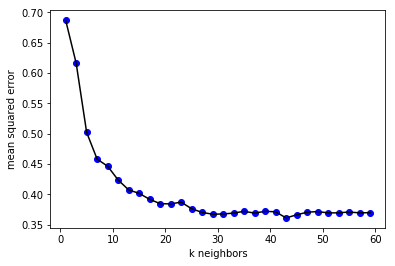

In [96]:
plt.plot(chk['n'],chk['mse'],'bo',chk['n'],chk['mse'],'k')
plt.xlabel('k neighbors')
plt.ylabel('mean squared error')
#plt.title('MSE vs. K-Neighbors graph')
plt.savefig('fig1')

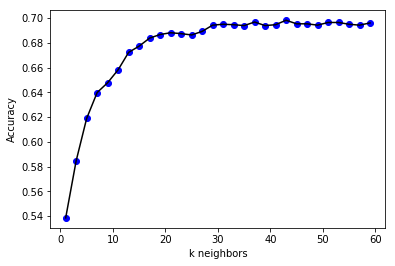

In [97]:
plt.plot(chk['n'],chk['acc'],'bo',chk['n'],chk['acc'],'k')
plt.xlabel('k neighbors')
plt.ylabel('Accuracy')
#plt.title('Accuracy vs. K-Neighbors graph')
plt.savefig('fig2')

In [85]:
def find_result(i):  
    knnclf = neighbors.KNeighborsClassifier(i, weights='distance')
    knnclf.fit(train_array, train_rating)


    predctions = knnclf.predict(test_array)
   
    print("Classification Report ...")
    print(classification_report(test_rating,predctions))

    print("Confussion Matrix....")
    print(confusion_matrix(test_rating,predctions))


    print("n_neighbors  ",i)
    print("Accuracy:    ",accuracy_score(test_rating, predctions))
    print("MSE:         ",mean_squared_error(test_rating, predctions))
    print("\n")

In [86]:
find_result(1)

Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.15      0.19      0.17        69
          3       0.30      0.32      0.31       586
          4       0.74      0.65      0.69      1906
          5       0.14      0.25      0.18       208

avg / total       0.59      0.54      0.56      2771

Confussion Matrix....
[[   0    1    0    1    0]
 [   0   13   26   22    8]
 [   0   33  185  305   63]
 [   1   39  367 1242  257]
 [   1    2   47  106   52]]
n_neighbors   1
Accuracy:     0.538433778419
MSE:          0.686755683869




In [88]:
find_result(5)

Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.21      0.10      0.14        69
          3       0.33      0.31      0.32       586
          4       0.73      0.79      0.76      1906
          5       0.13      0.08      0.10       208

avg / total       0.59      0.62      0.60      2771

Confussion Matrix....
[[   0    1    0    1    0]
 [   0    7   28   31    3]
 [   0   15  179  376   16]
 [   0   10  294 1512   90]
 [   0    0   44  147   17]]
n_neighbors   5
Accuracy:     0.618910140743
MSE:          0.501984843017




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [89]:
find_result(10)

Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.22      0.06      0.09        69
          3       0.34      0.25      0.29       586
          4       0.72      0.86      0.79      1906
          5       0.21      0.06      0.09       208

avg / total       0.59      0.65      0.61      2771

Confussion Matrix....
[[   0    0    2    0    0]
 [   0    4   26   39    0]
 [   0   14  145  422    5]
 [   0    0  220 1645   41]
 [   0    0   33  163   12]]
n_neighbors   10
Accuracy:     0.65175027066
MSE:          0.433778419343




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
find_result(15)

Classification Report ...
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.50      0.06      0.10        69
          3       0.37      0.22      0.27       586
          4       0.72      0.91      0.81      1906
          5       0.38      0.03      0.05       208

avg / total       0.62      0.68      0.62      2771

Confussion Matrix....
[[   0    0    2    0    0]
 [   0    4   26   39    0]
 [   0    4  127  452    3]
 [   0    0  159 1740    7]
 [   0    0   29  173    6]]
n_neighbors   15
Accuracy:     0.677372789607
MSE:          0.401660050523




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
chk

,acc,mse,n
0,0.538434,0.686756,1.0
1,0.584626,0.616023,3.0
2,0.618910,0.501985,5.0
3,0.639841,0.457957,7.0
4,0.647781,0.446409,9.0
5,0.658246,0.423674,11.0
6,0.672320,0.407434,13.0
7,0.677373,0.401660,15.0
8,0.683869,0.391916,17.0
9,0.686756,0.384699,19.0
